In [21]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from cenpy import products
from census import Census
from dotenv import load_dotenv
from IPython.display import display, HTML
from sodapy import Socrata

In [ ]:
load_dotenv()

SOCRATA_API_KEY = os.getenv('SOCRATA_API_KEY')
CENSUS_API_KEY =  os.getenv('CENSUS_API_KEY')
USERNAME = os.getenv('USERNAME')
PASSWORD = os.getenv('PASSWORD')


In [11]:
client = Socrata("data.cityofnewyork.us",
                SOCRATA_API_KEY,
                USERNAME,
                PASSWORD)

In [12]:
limit = 1000
all_records = []
offset = 0

while True:
    results = client.get("43nn-pn8j", limit=limit, offset=offset)
    all_records.extend(results)
    offset += limit
    if len(results) < limit:
        break

nyc_res_df = pd.DataFrame.from_records(all_records)

client.close()

print(f"Number of records in the DataFrame: {len(nyc_res_df)}")


Number of records in the DataFrame: 219276


## Exploratory Data Analysis


In [15]:
nyc_res_df['violation_combined'] = nyc_res_df['violation_code'] + ': ' + nyc_res_df['violation_description']

violation_counts = nyc_res_df['violation_combined'].value_counts().reset_index()
violation_counts.columns = ['violation_combined', 'counts']

# Find the latest year in your dataset
latest_year = nyc_res_df['inspection_date'].dt.year.max()

# Filter the DataFrame for the latest year
df_last_year = nyc_res_df[nyc_res_df['inspection_date'].dt.year == latest_year]

# Count the occurrences for the last year
violation_counts_last_year = df_last_year['violation_combined'].value_counts().reset_index()
violation_counts_last_year.columns = ['violation_combined', 'counts_last_year']

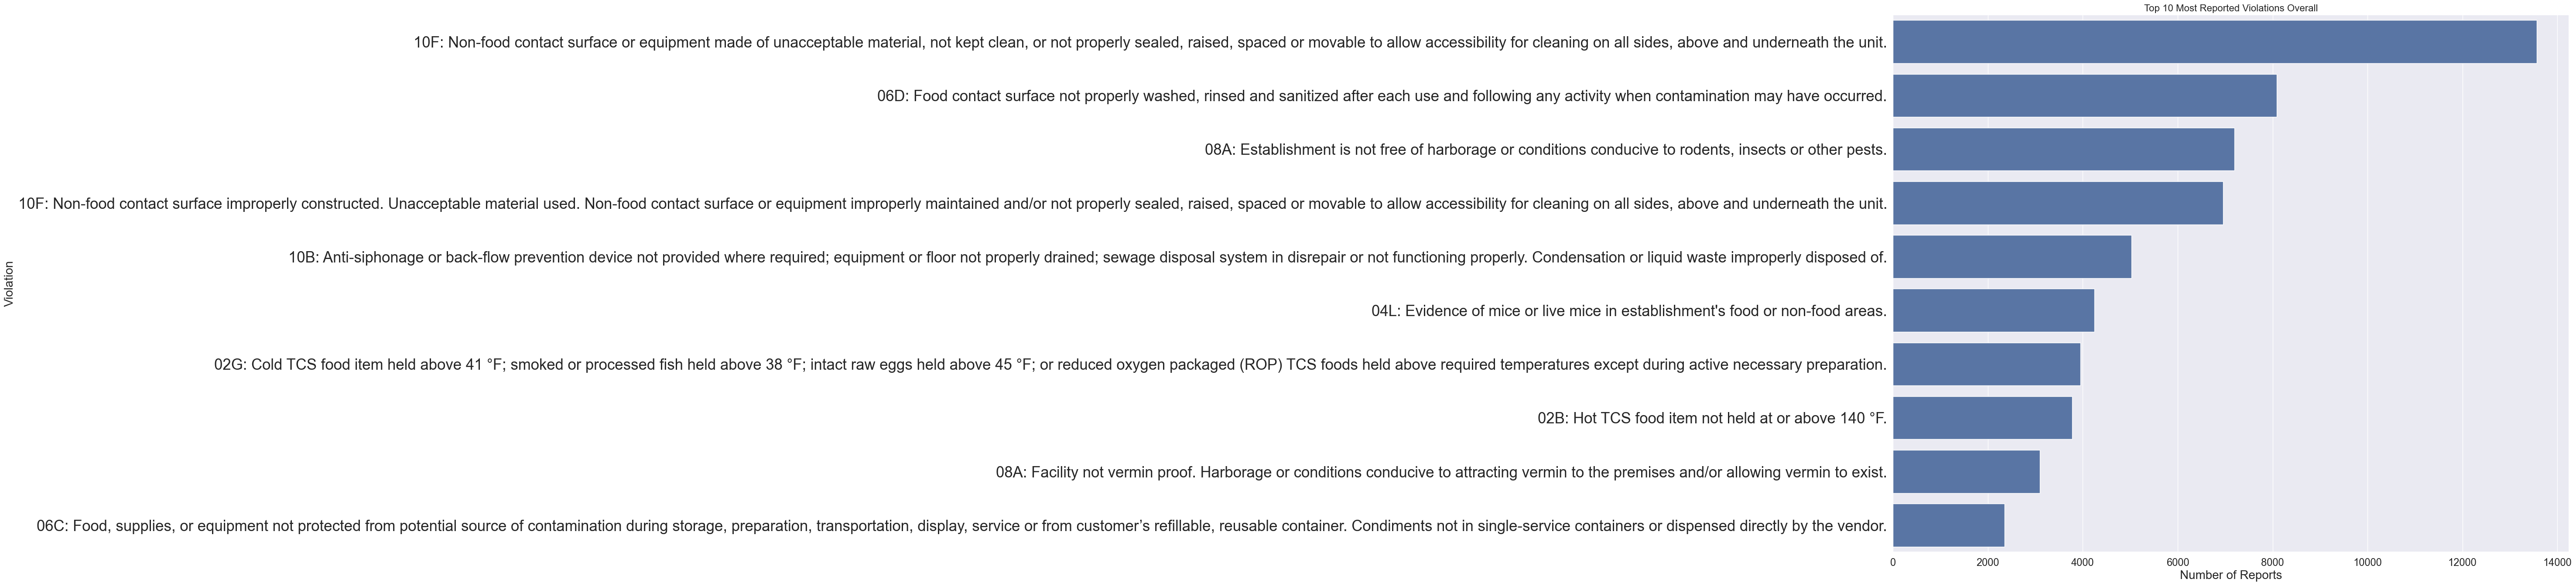

In [16]:
plt.figure(figsize=(20,  16))

sns.set(font_scale=1.2)

sns.barplot(x='counts', y='violation_combined', data=violation_counts.head(10))

plt.title('Top 10 Most Reported Violations Overall', fontsize=16)
plt.xlabel('Number of Reports', fontsize=20)
plt.ylabel('Violation', fontsize=20)

plt.xticks(fontsize=17)
plt.yticks(fontsize=25)

plt.tight_layout()
plt.show()


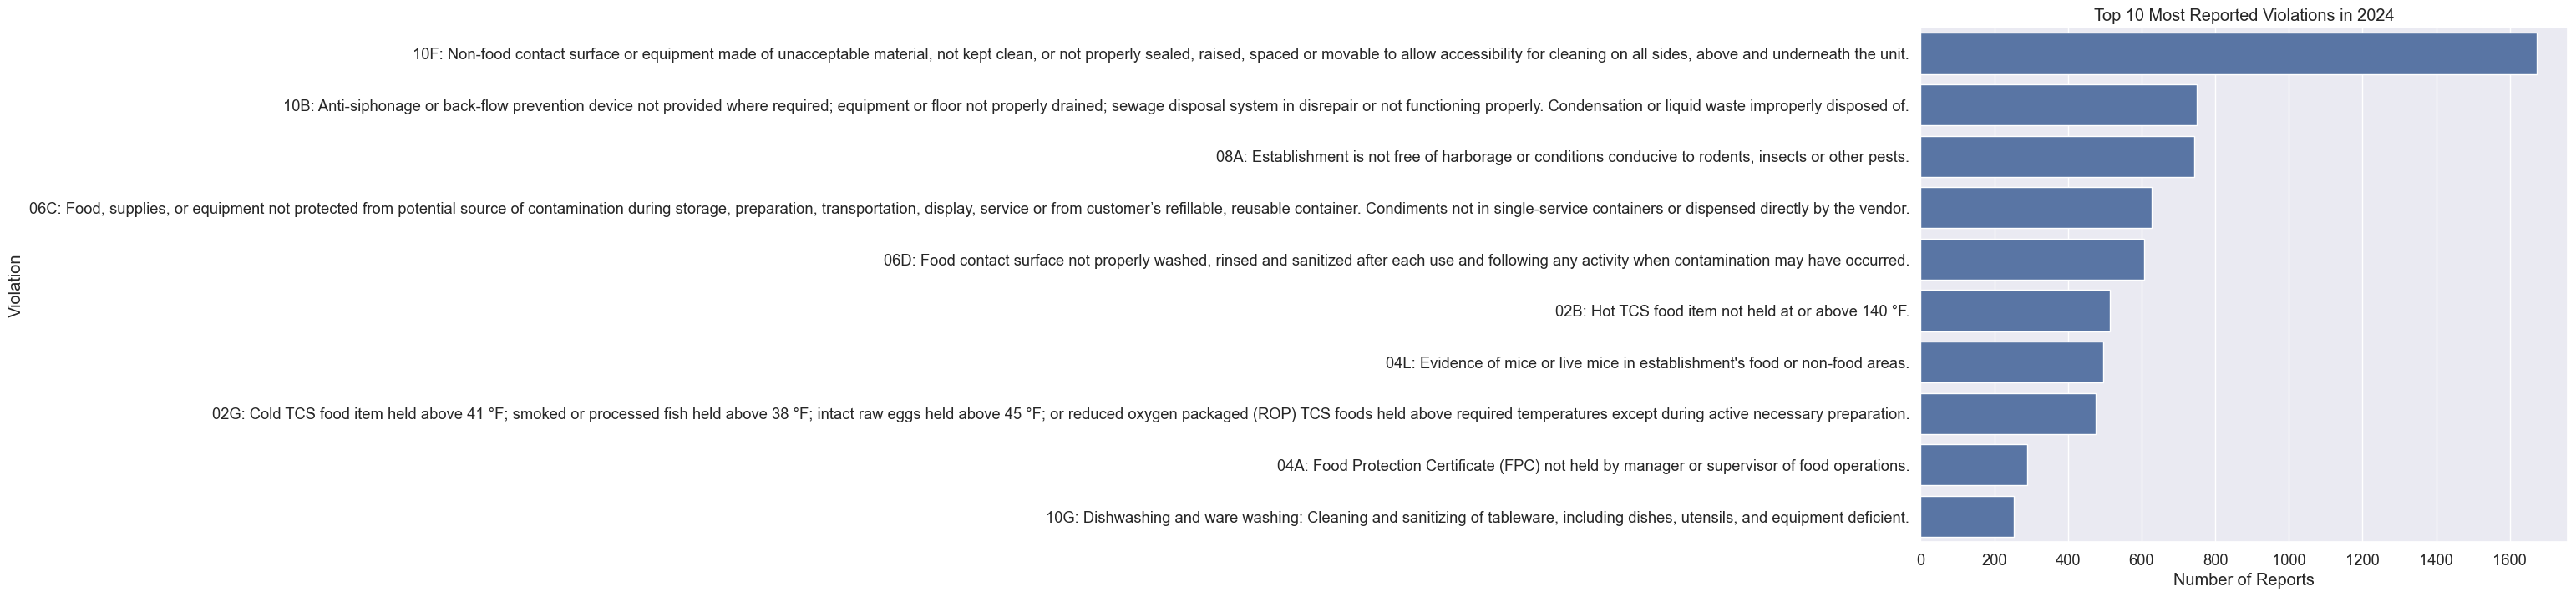

In [17]:
# Plotting the top 10 most reported violations in 2024
plt.figure(figsize=(10, 8))
sns.barplot(x='counts_last_year', y='violation_combined', data=violation_counts_last_year.head(10))
plt.title(f'Top 10 Most Reported Violations in {latest_year}')
plt.xlabel('Number of Reports')
plt.ylabel('Violation')
plt.tight_layout()
plt.show()


inspection_year
2015       10
2016      183
2017      534
2018      816
2019     2514
2020     2595
2021     7453
2022    37086
2023    44598
2024     9391
dtype: int64


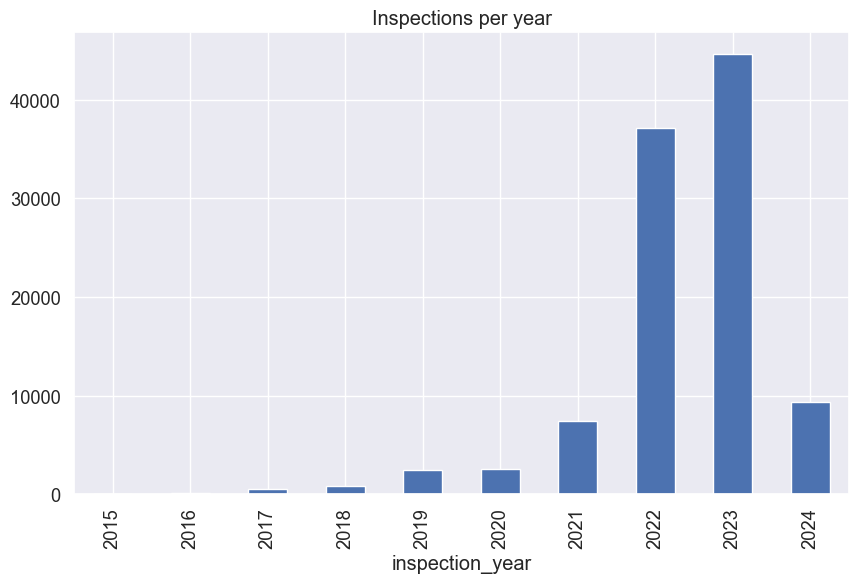

In [24]:
# # Number of inspections over time

nyc_res_df['inspection_year'] = nyc_res_df['inspection_date'].dt.year
# Calculate inspections per year
inspections_per_year = nyc_res_df.groupby('inspection_year').size()
print(inspections_per_year)
plt.figure(figsize=(10, 6))
inspections_per_year.plot(kind='bar', title='Inspections per year')
plt.show()

## Data Preparation and Preprocessing 

- Dropping rows in which have NaN values in the `score`, `grade`, `census_tract`, `dba` (restaurant name) columns.

In [23]:
# Convert inspection_date to datetime
nyc_res_df['inspection_date'] = pd.to_datetime(nyc_res_df['inspection_date'])
nyc_res_df['grade_date'] = pd.to_datetime(nyc_res_df['grade_date'])
nyc_res_df['record_date'] = pd.to_datetime(nyc_res_df['record_date'])

# Handle missing values and drop columns where census_tract, grade, score, dba is missing.
nyc_res_df.dropna(subset=['score', 'grade', 'census_tract', 'dba'], inplace=True)

# # Remove duplicates (if applicable)
# nyc_res_df.drop_duplicates(inplace=True)

- Aggregating data on restaurant level

In [25]:
restaurants_agg_df = nyc_res_df.sort_values('inspection_date').groupby('camis').last()
restaurants_agg_df

,dba,boro,building,street,zipcode,phone,inspection_date,critical_flag,record_date,latitude,...,cuisine_description,action,score,grade,grade_date,inspection_type,violation_code,violation_description,violation_combined,inspection_year
camis,,,,,,,,,,,,,,,,,,,,,
30075445,MORRIS PARK BAKE SHOP,Bronx,1007,MORRIS PARK AVENUE,10462,7188924968,2023-08-22,Not Critical,2024-03-11 06:00:08,40.848231224526,...,Bakery Products/Desserts,Violations were cited in the following area(s).,12,A,2023-08-22,Cycle Inspection / Re-inspection,08A,Establishment is not free of harborage or cond...,08A: Establishment is not free of harborage or...,2023
30112340,WENDY'S,Brooklyn,469,FLATBUSH AVENUE,11225,7182875005,2023-07-21,Not Critical,2024-03-11 06:00:08,40.662651518808,...,Hamburgers,Violations were cited in the following area(s).,9,A,2023-07-21,Cycle Inspection / Initial Inspection,10B,Anti-siphonage or back-flow prevention device ...,10B: Anti-siphonage or back-flow prevention de...,2023
30191841,DJ REYNOLDS PUB AND RESTAURANT,Manhattan,351,WEST 57 STREET,10019,2122452912,2023-04-23,Critical,2024-03-11 06:00:08,40.767325711553,...,Irish,Violations were cited in the following area(s).,10,A,2023-04-23,Cycle Inspection / Initial Inspection,06E,"Sanitized equipment or utensil, including in-u...","06E: Sanitized equipment or utensil, including...",2023
40356018,RIVIERA CATERERS,Brooklyn,2780,STILLWELL AVENUE,11224,7183723031,2022-02-01,Critical,2024-03-11 06:00:08,40.579895663312,...,American,Violations were cited in the following area(s).,7,A,2022-02-01,Cycle Inspection / Initial Inspection,02G,Cold food item held above 41º F (smoked fish a...,02G: Cold food item held above 41º F (smoked f...,2022
40356483,WILKEN'S FINE FOOD,Brooklyn,7114,AVENUE U,11234,7184443838,2022-08-19,Not Critical,2024-03-11 06:00:08,40.620111590927,...,Sandwiches,Violations were cited in the following area(s).,2,A,2022-08-19,Cycle Inspection / Re-inspection,10F,Non-food contact surface or equipment made of ...,10F: Non-food contact surface or equipment mad...,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50147508,MEI MEI NOODLE HOUSE,Queens,13335,ROOSEVELT AVE,11354,3476679413,2024-02-28,Critical,2024-03-11 06:00:08,40.758501995257,...,Chinese,Violations were cited in the following area(s).,39,N,NaT,Pre-permit (Non-operational) / Initial Inspection,05H,No approved written standard operating procedu...,05H: No approved written standard operating pr...,2024
50147662,SAWA,Brooklyn,75,5 AVENUE,11217,6465411894,2024-03-05,Not Critical,2024-03-11 06:00:08,40.680436289981,...,Mediterranean,Violations were cited in the following area(s).,10,N,NaT,Pre-permit (Non-operational) / Initial Inspection,10B,Anti-siphonage or back-flow prevention device ...,10B: Anti-siphonage or back-flow prevention de...,2024
50147713,NATURAL JUICE BAR CAFE,Queens,709,SENECA AVENUE,11385,3479939643,2024-03-05,Not Critical,2024-03-11 06:00:08,40.702694179178,...,"Juice, Smoothies, Fruit Salads",Violations were cited in the following area(s).,11,A,2024-03-05,Pre-permit (Operational) / Initial Inspection,08A,Establishment is not free of harborage or cond...,08A: Establishment is not free of harborage or...,2024


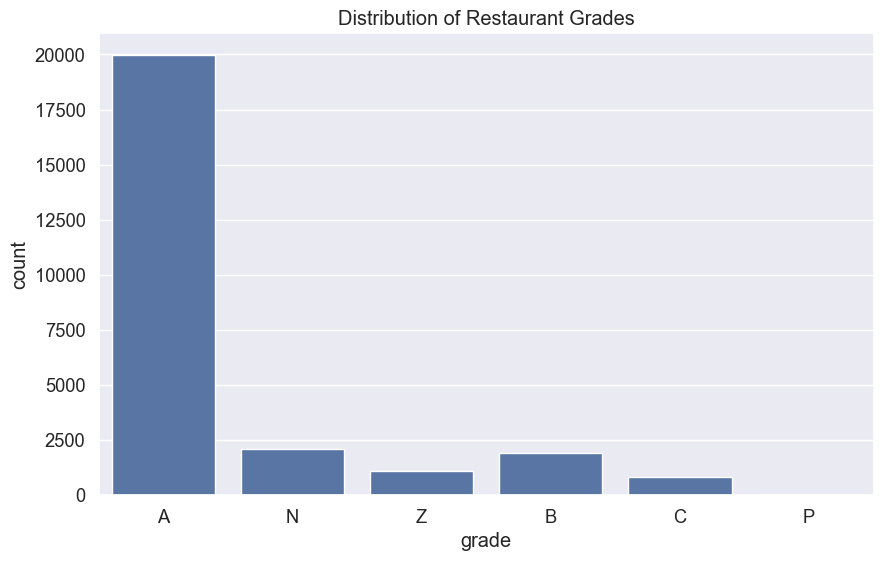

In [29]:
# Distribution of grades
plt.figure(figsize=(10, 6))

# Create the count plot
sns.countplot(x='grade', data=restaurants_agg_df)
plt.title('Distribution of Restaurant Grades')

# Show the plot
plt.show()

In [28]:
grade_counts = restaurants_agg_df['grade'].value_counts()

# Print the counts for each grade
print(grade_counts)

grade
A    19964
N     2111
B     1932
Z     1115
C      814
P        1
Name: count, dtype: int64


- Fetching Census Data 

In [32]:
c = Census(CENSUS_API_KEY)

# Variables to fetch
variables = {
    'B19013_001E': 'median_household_income',
    'B01003_001E': 'total_population',
    'B02001_004E': 'asian_population',
    'B02001_002E': 'white_population',
    'B02001_003E': 'black_population',
    'B15003_022E': 'no_college_population',
    'B17001_002E': 'poverty_rate',
}

# FIPS codes for New York State and NYC counties
state_fips = '36'
nyc_counties = ['005', '047', '061', '081', '085']  # Corresponding to NYC boroughs

# Fetch and combine data for each NYC county
population_data = pd.DataFrame()
for county_fips in nyc_counties:
    county_data = c.acs5.state_county_tract(
        tuple(variables.keys()),
        state_fips=state_fips,
        county_fips=county_fips,
        tract='*'
    )
    population_data = pd.concat([population_data, pd.DataFrame(county_data)], ignore_index=True)

# Rename the columns according to the variables dictionary
population_data = population_data.rename(columns=variables)

# Include a column for the full FIPS code of each census tract
population_data['full_tract_fips'] = population_data.apply(lambda row: row['state'] + row['county'] + row['tract'], axis=1)

population_data

,median_household_income,total_population,asian_population,white_population,black_population,no_college_population,poverty_rate,state,county,tract,full_tract_fips
0,-666666666.0,6661.0,39.0,2680.0,3272.0,108.0,0.0,36,005,000100,36005000100
1,70867.0,4453.0,0.0,1235.0,1262.0,472.0,1014.0,36,005,000200,36005000200
2,98090.0,6000.0,18.0,1809.0,1472.0,821.0,240.0,36,005,000400,36005000400
3,40033.0,6038.0,213.0,996.0,2322.0,528.0,951.0,36,005,001600,36005001600
4,55924.0,2168.0,27.0,664.0,868.0,283.0,596.0,36,005,001901,36005001901


In [34]:
# Adding full_tract_fips columns to aggregated restaurants data.

boro_to_county_fips = {
    'Bronx': '005',
    'Brooklyn': '047',
    'Manhattan': '061',
    'Queens': '081',
    'Staten Island': '085'
}

def create_full_tract_fips(row):
    county_fips = boro_to_county_fips.get(row['boro'])  # Get the county FIPS code based on the borough
    census_tract = row['census_tract']
    return f'36{county_fips}{census_tract}'

# Apply the function to each row of the DataFrame to create the 'full_tract_fips' column
restaurants_agg_df['full_tract_fips'] = restaurants_agg_df.apply(create_full_tract_fips, axis=1)

- Merging restaurants_agg_df with population_data.

In [35]:
restaurants_agg_df['full_tract_fips'] = restaurants_agg_df['full_tract_fips'].astype(str)
population_data['full_tract_fips'] = population_data['full_tract_fips'].astype(str)

rest_demo_df = pd.merge(restaurants_agg_df, population_data, left_on='full_tract_fips', right_on='full_tract_fips', how='left')
rest_demo_df

,dba,boro,building,street,zipcode,phone,inspection_date,critical_flag,record_date,latitude,...,median_household_income,total_population,asian_population,white_population,black_population,no_college_population,poverty_rate,state,county,tract
0,MORRIS PARK BAKE SHOP,Bronx,1007,MORRIS PARK AVENUE,10462,7188924968,2023-08-22,Not Critical,2024-03-11 06:00:08,40.848231224526,...,71042.0,2561.0,77.0,1182.0,167.0,364.0,343.0,36,005,025200
1,WENDY'S,Brooklyn,469,FLATBUSH AVENUE,11225,7182875005,2023-07-21,Not Critical,2024-03-11 06:00:08,40.662651518808,...,58750.0,2870.0,49.0,832.0,1674.0,765.0,474.0,36,047,032700
2,DJ REYNOLDS PUB AND RESTAURANT,Manhattan,351,WEST 57 STREET,10019,2122452912,2023-04-23,Critical,2024-03-11 06:00:08,40.767325711553,...,103362.0,10203.0,238.0,7136.0,661.0,4012.0,807.0,36,061,013900
3,RIVIERA CATERERS,Brooklyn,2780,STILLWELL AVENUE,11224,7183723031,2022-02-01,Critical,2024-03-11 06:00:08,40.579895663312,...,49256.0,2851.0,0.0,697.0,229.0,296.0,874.0,36,047,034800
4,WILKEN'S FINE FOOD,Brooklyn,7114,AVENUE U,11234,7184443838,2022-08-19,Not Critical,2024-03-11 06:00:08,40.620111590927,...,84034.0,1344.0,0.0,1130.0,172.0,171.0,43.0,36,047,070000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25932,MEI MEI NOODLE HOUSE,Queens,13335,ROOSEVELT AVE,11354,3476679413,2024-02-28,Critical,2024-03-11 06:00:08,40.758501995257,...,39261.0,3589.0,14.0,153.0,465.0,582.0,722.0,36,081,087100
25933,SAWA,Brooklyn,75,5 AVENUE,11217,6465411894,2024-03-05,Not Critical,2024-03-11 06:00:08,40.680436289981,...,133250.0,2996.0,0.0,1828.0,453.0,978.0,291.0,36,047,012902
25934,NATURAL JUICE BAR CAFE,Queens,709,SENECA AVENUE,11385,3479939643,2024-03-05,Not Critical,2024-03-11 06:00:08,40.702694179178,...,82727.0,6139.0,16.0,3513.0,206.0,809.0,665.0,36,081,054900
25935,BOOLEY'S RESTAURANT & BAKERY,Brooklyn,1500,SHEEPSHEAD BAY ROAD,11235,9298162819,2024-03-07,Not Critical,2024-03-11 06:00:08,40.58726846017,...,71994.0,2896.0,0.0,2105.0,14.0,993.0,399.0,36,047,060600


In [36]:
# Add black_perct, asian_perct, white_perct, and no_coll_perct columns to the merged rest_demo_df

rest_demo_df['asian_perct'] = (rest_demo_df['asian_population'].fillna(0) / rest_demo_df['total_population'].fillna(0)) * 100
rest_demo_df['black_perct'] = (rest_demo_df['black_population'].fillna(0) / rest_demo_df['total_population'].fillna(0)) * 100
rest_demo_df['white_perct'] = (rest_demo_df['white_population'].fillna(0) / rest_demo_df['total_population'].fillna(0)) * 100
rest_demo_df['no_coll_perct'] = (rest_demo_df['no_college_population'].fillna(0) / rest_demo_df['total_population'].fillna(0)) * 100

- Dropping rows where `black_perct`, `asian_perct``, white_perct`, and `no_coll_perct` have NaN values
- Dropping rows where `median_household_income` is negative.


In [37]:
rest_demo_clean_df = rest_demo_df.dropna(subset=['asian_perct', 'black_perct', 'white_perct', 'no_coll_perct'])
rest_demo_clean_df = rest_demo_df[rest_demo_df['median_household_income'] >= 0]


In [38]:
# Filter for each grade and get their counts after preprocessing

num_a_grades = rest_demo_clean_df[rest_demo_clean_df['grade'] == 'A'].shape[0]
num_b_grades = rest_demo_clean_df[rest_demo_clean_df['grade'] == 'B'].shape[0]
num_c_grades = rest_demo_clean_df[rest_demo_clean_df['grade'] == 'C'].shape[0]
num_n_grades = rest_demo_clean_df[rest_demo_clean_df['grade'] == 'N'].shape[0]
num_z_grades = rest_demo_clean_df[rest_demo_clean_df['grade'] == 'Z'].shape[0]


print("Number of A graded restaurants:", num_a_grades)
print("Number of B graded restaurants:", num_b_grades)
print("Number of N graded restaurants:", num_n_grades)
print("Number of C graded restaurants:", num_c_grades)
print("Number of Z graded restaurants:", num_z_grades)

Number of A graded restaurants: 17603
Number of B graded restaurants: 1694
Number of N graded restaurants: 1855
Number of C graded restaurants: 724
Number of Z graded restaurants: 980


- Since the data is highly imbalanced we will do resampling.
- Add a column binary_grade [1 if grade is A else 0]
- Upsample the minorty class and downsample the minority class.

In [40]:
# Create a copy of DataFrame
rest_model_df = rest_demo_clean_df.copy()

rest_model_df['binary_grade'] = rest_model_df['grade'].apply(lambda x: 1 if x == 'A' else 0)

# Separate majority (A) and minority (Not A) classes
df_majority = rest_model_df[rest_model_df.binary_grade == 1]
df_minority = rest_model_df[rest_model_df.binary_grade == 0]

# Downsampling the majority class
downsample_size = int(len(df_majority) * 0.75)  # Adjust the fraction as needed
df_majority_downsampled = resample(df_majority, 
                                replace=False, 
                                n_samples=downsample_size, 
                                random_state=123)

# Upsampling the minority class
upsample_size = int(len(df_minority) * 2)  # Adjust the multiplier as needed
df_minority_upsampled = resample(df_minority,
                                replace=True,
                                n_samples=upsample_size,
                                random_state=123)

# Combining the downsampled majority and upsampled minority classes
rest_model_balanced = pd.concat([df_majority_downsampled, df_minority_upsampled])

# Shuffling the dataset
rest_model_balanced = rest_model_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# save as csv-file 

rest_model_balanced.to_csv('Data/rest_model_balanced.csv', sep=',', encoding='utf-8', index=False)

# Display the new class distribution
print(rest_model_balanced['binary_grade'].value_counts())


binary_grade
1    13202
0    10506
Name: count, dtype: int64
